In [1]:
import datetime
import time

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import notebook_libs.utilities as util
import notebook_libs.prometheus as prom

## Experiment in Progress - Client Data

In [ ]:
while True:
    print(f"Updated {datetime.datetime.now()}")
    df = util.read_client_requests_in_progress()
    f, ax = plt.subplots(figsize=[8,4])
    util.plot_client_latency_distribution(df, "in-progress", ax)
    plt.show()
    result = prom.fetch_experiment_pod_data(int(14000/60.))
    util.plot_pod_metrics(result)
    plt.show()
    time.sleep(200)

## Experiment in Progress - Prometheus Data

In [ ]:
result = prom.fetch_experiment_pod_data(int(12000/60.))
util.plot_pod_metrics(result)

## Completed Experiment

In [3]:
print("\n".join([f"{i}: {x}" for i, x in enumerate(util.experiments)]))

0: 2023-02-15_2-replicas
1: 2023-02-16_4-replicas
2: 2023-02-16_6-replicas
3: 2023-02-17_3-replicas
4: 2023-02-17_5-replicas
5: 2023-02-19_2-replicas
6: 2023-02-20_5-replicas
7: 2023-02-15_3-replicas
8: 2023-02-16_5-replicas
9: 2023-02-16_6-replicas-2
10: 2023-02-17_4-replicas
11: 2023-02-18_3-replicas
12: 2023-02-19_4-replicas


In [4]:
current_experiment = util.experiments[6]

### Persist Data

In [ ]:
# current_experiment
# util.persist_pod_dfs(result, current_experiment)
# util.persist_pod_dfs(result, "tmp")

### Create 1-Minute buckets for client request data

In [ ]:
df, first_request_time, final_request_time = util.read_client_requests(current_experiment)
df_bucket = util.create_1_min_bucket_client_metrics(df)
df_bucket.plot(y=[
    "request_rate_per_min", 
    "avg_client_latency_ms",
    "std_client_latency_ms",
    "avg_response_function_latency_ms",
    "std_response_function_latency_ms"
]
,figsize=[8,12]
,title="Client Metrics (1Min Buckets)")

### Determine window boundaries

In [5]:
df_client, first_request_time, final_request_time = util.read_client_requests(current_experiment)
first_request_time = int(first_request_time)
final_request_time = int(final_request_time + 120)
print(first_request_time, final_request_time)

1676938046 1676948136


In [6]:
df_client.describe()

,client_latency_ms,response_start_time_sec,response_function_latency_ms,response_memory_request,response_memory_usage_mb,response_sleep_delay_ms,response_load_time_ms,response_load_request,response_load_calibration,bucket_1_min
count,48000.000000,4.800000e+04,48000.000000,48000.0,48000.000000,48000.0,48000.000000,48000.0,48000.0,4.800000e+04
mean,694.886363,1.676943e+09,492.585733,250.0,292.009666,200.0,20.869325,10.0,15000.0,1.676943e+09
std,233.225391,2.183354e+03,52.552882,0.0,1.009061,0.0,3.486486,0.0,0.0,2.183432e+03
min,426.808119,1.676938e+09,405.978680,250.0,289.882812,200.0,17.835617,10.0,15000.0,1.676938e+09
25%,534.907103,1.676941e+09,488.425374,250.0,291.269531,200.0,18.646002,10.0,15000.0,1.676941e+09
50%,602.730989,1.676943e+09,499.346256,250.0,291.707031,200.0,19.108891,10.0,15000.0,1.676943e+09
75%,807.093859,1.676945e+09,513.516605,250.0,291.957031,200.0,22.131741,10.0,15000.0,1.676945e+09
max,2247.380018,1.676948e+09,1504.639626,250.0,293.902344,200.0,119.858027,10.0,15000.0,1.676948e+09


## Compare a Group of Experiments

['2023-02-15_2-replicas', '2023-02-16_4-replicas', '2023-02-16_6-replicas', '2023-02-17_3-replicas', '2023-02-17_5-replicas', '2023-02-19_2-replicas', '2023-02-20_5-replicas', '2023-02-15_3-replicas', '2023-02-16_5-replicas', '2023-02-16_6-replicas-2', '2023-02-17_4-replicas', '2023-02-18_3-replicas', '2023-02-19_4-replicas']
2023-02-15_2-replicas
count    34997.000000
mean      1099.488524
std        407.907852
min        503.618002
25%        736.459970
50%       1054.556847
75%       1431.749821
max       3242.873907
Name: client_latency_ms, dtype: float64

2023-02-16_4-replicas
count    44998.000000
mean       728.320758
std        248.259402
min        500.531912
25%        539.703369
50%        606.315851
75%        963.607073
max       2469.373941
Name: client_latency_ms, dtype: float64

2023-02-16_6-replicas
count    50000.000000
mean       598.762926
std        146.411338
min        370.941877
25%        520.917654
50%        546.482801
75%        628.772259
max       2003.417

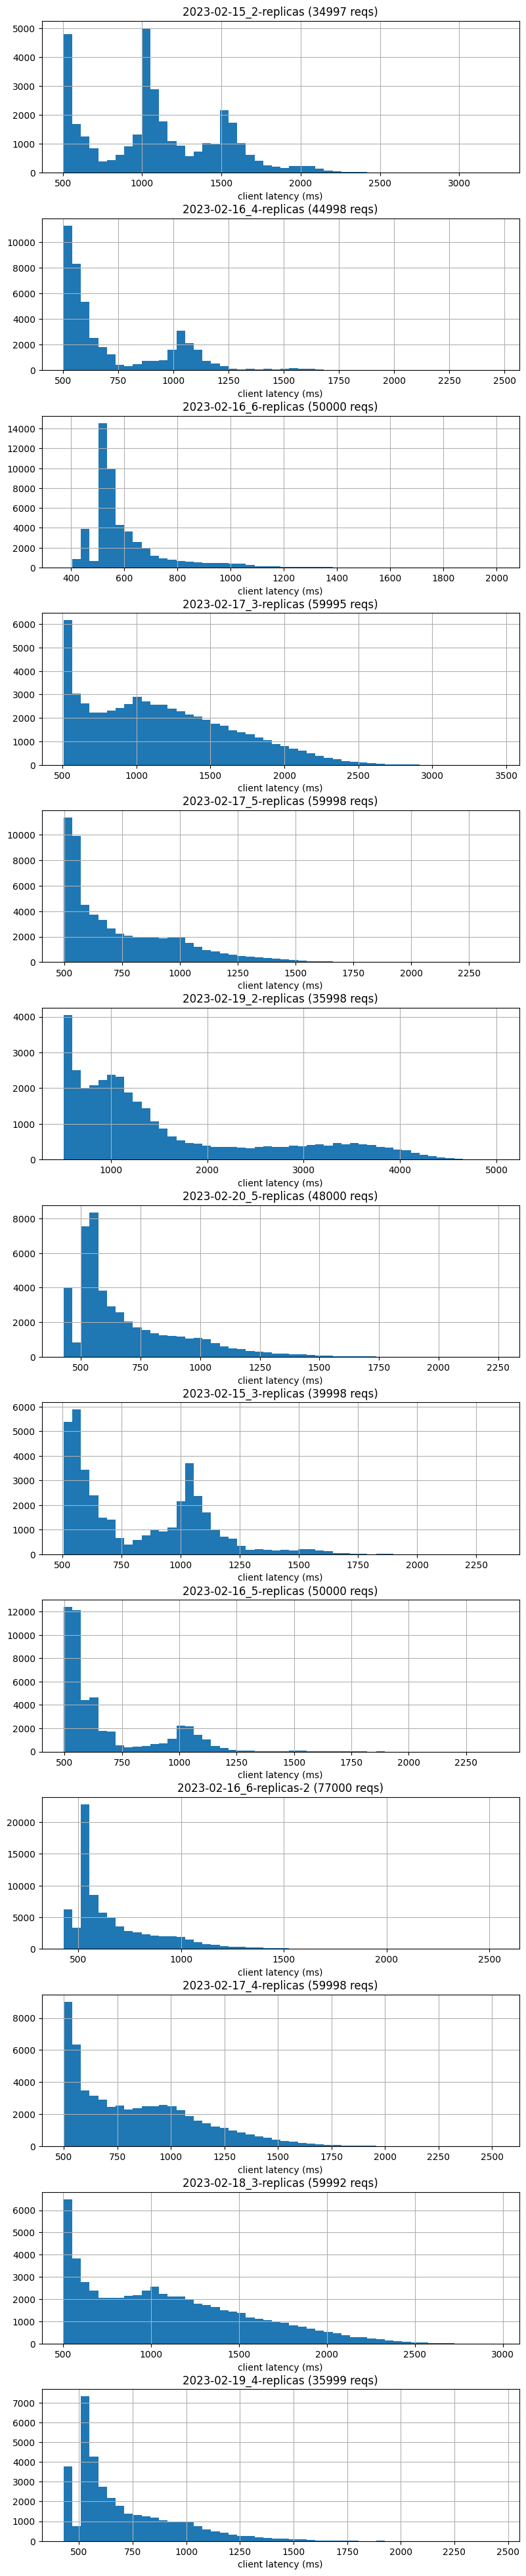

In [7]:
print(util.experiments)
util.compare_client_latency_distributions()

## Experiment Complete - Compare data window between Client and Prometheus

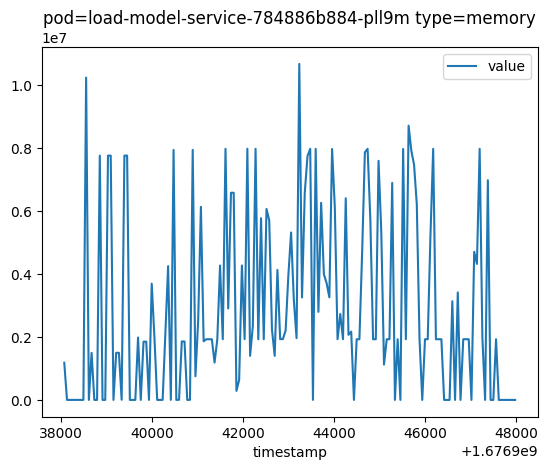

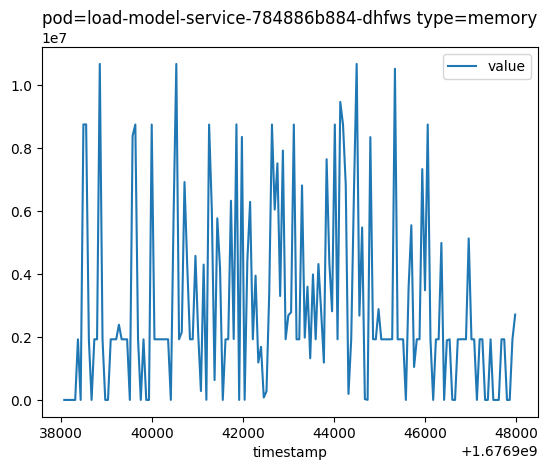

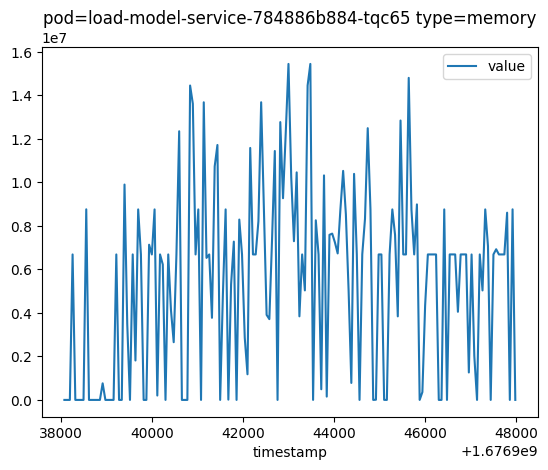

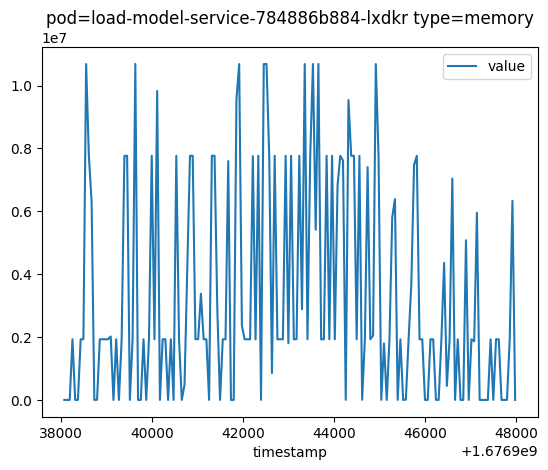

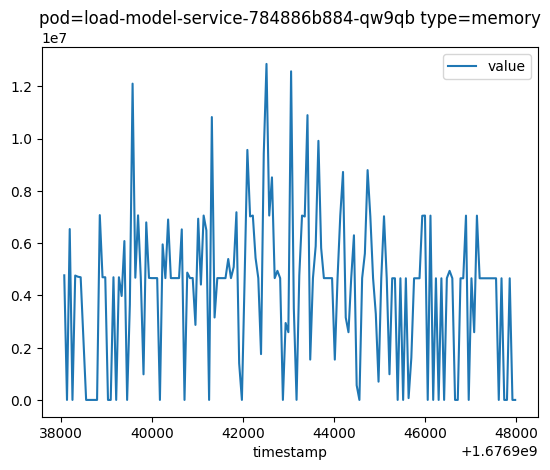

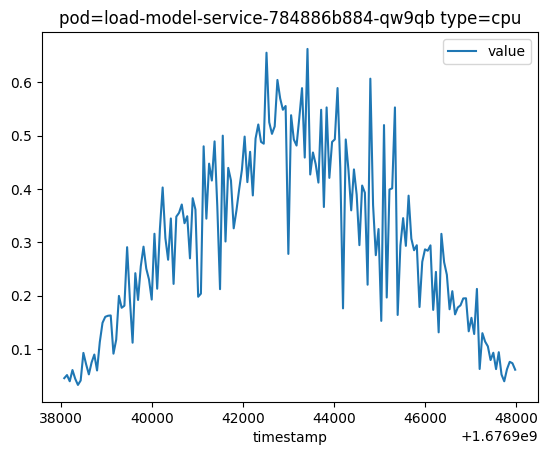

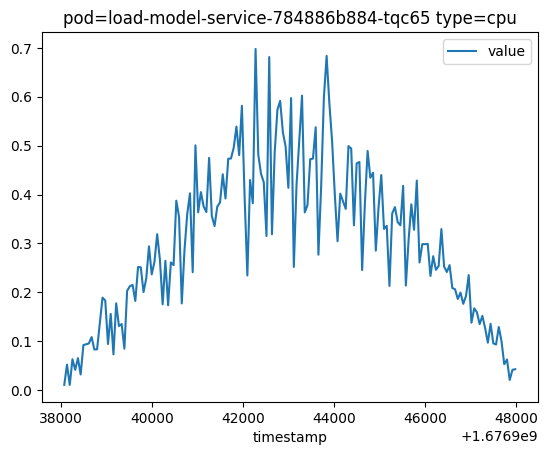

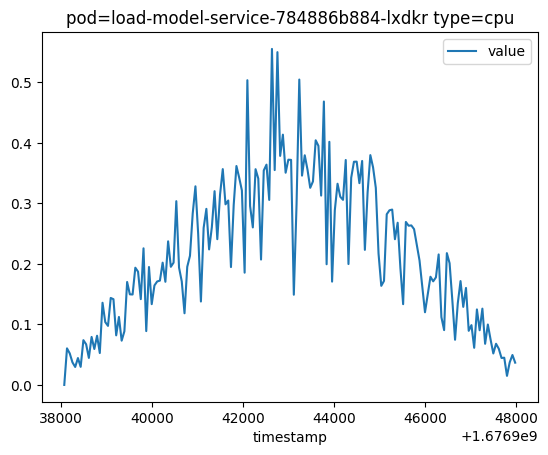

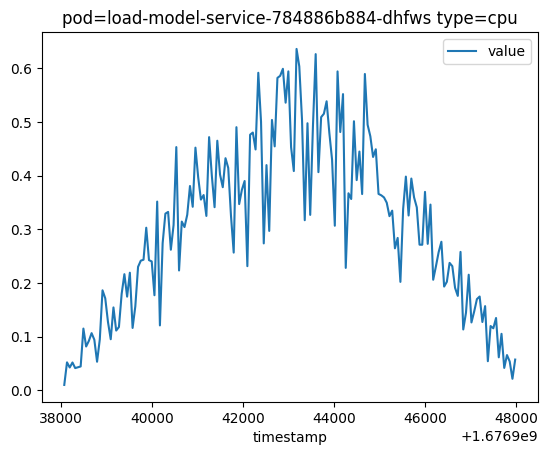

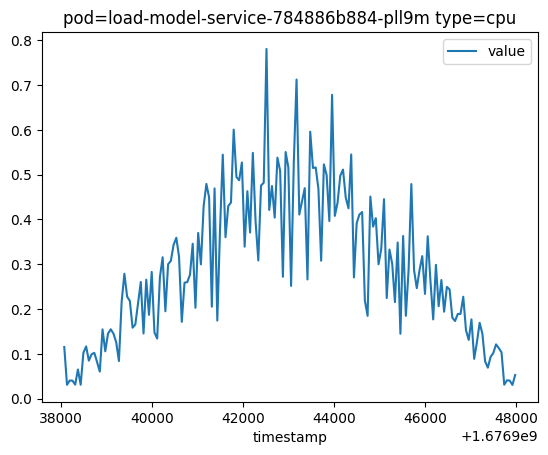

In [8]:
df_pod = util.read_pod_df_list(current_experiment, first_request_time, final_request_time)
util.plot_pod_metrics(df_pod)

In [5]:
df = util.combined_data_set(current_experiment)
df.head(10)

,memory,cpu,request_rate_per_min,avg_client_latency_ms,std_client_latency_ms,avg_response_function_latency_ms,std_response_function_latency_ms,avg_response_memory_usage_mb,std_response_memory_usage_mb,avg_response_load_time_ms,std_response_load_time_ms,replicas
timestamp,,,,,,,,,,,,
1676938080,1.189945e+06,0.036390,48,583.428164,94.541084,498.611704,75.242577,291.885905,1.268005,21.325320,2.909911,5
1676938140,8.192000e+01,0.049424,45,576.574537,59.792065,484.657155,44.221657,291.808507,1.231917,22.117556,4.306186,5
1676938200,1.307807e+06,0.037141,44,576.827607,78.835815,489.356995,41.527850,291.890625,1.248392,21.519986,2.705147,5
1676938260,1.723404e+06,0.050689,46,613.220329,110.778454,492.507950,43.898235,291.776664,1.308842,21.649133,2.837981,5
1676938320,9.518012e+05,0.037699,46,596.852562,123.614529,506.484135,84.688372,291.901919,1.263560,21.824510,3.311066,5
1676938380,1.328232e+06,0.050166,46,574.476346,68.781105,492.069120,45.262158,291.757558,1.268251,21.708924,2.943398,5
1676938440,1.324756e+06,0.035758,90,569.689788,92.749747,486.350817,48.139912,291.742014,1.250894,21.443804,2.754334,5
1676938500,2.600605e+06,0.095311,93,582.765938,116.058372,489.115179,44.189675,291.794019,1.301444,21.522778,2.739931,5
1676938560,7.691305e+06,0.086174,89,578.214327,85.832496,495.172233,46.804820,291.723885,1.270554,21.727811,3.095995,5


<Axes: xlabel='request_rate_per_min', ylabel='memory'>

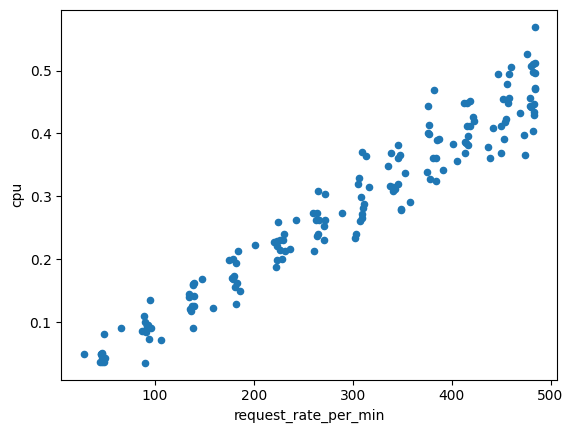

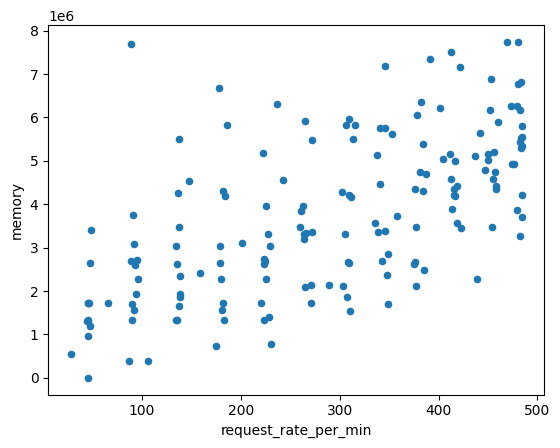

In [6]:
df.plot.scatter(x="request_rate_per_min",y="cpu")
df.plot.scatter(x="request_rate_per_min",y="memory")

## concatinate many experiments

In [7]:
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

2023-02-22 17:05:44.955520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
df_train = df[[ "memory", "cpu", "request_rate_per_min", "avg_client_latency_ms", "replicas"]].copy()

scaler.fit(df_train)
scaled = scaler.fit_transform(df_train)
scaled_df = pd.DataFrame(scaled, columns=df_train.columns)

dataset = scaled_df.to_numpy()
X = dataset[:,[2,4]]
y = dataset[:,[0,1,3]]

In [19]:
model = Sequential()
model.add(Dense(15, input_shape=(2,), activation='relu'))
model.add(Dense(11, activation='relu'))
model.add(Dense(3, activation='relu'))
# compile the keras model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X, y, epochs=350, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/350
17/17 [==============================] - 1s 1ms/step - loss: 0.1252 - accuracy: 0.5060
Epoch 2/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0961 - accuracy: 0.4036
Epoch 3/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0901 - accuracy: 0.3855
Epoch 4/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0892 - accuracy: 0.2771
Epoch 5/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0889 - accuracy: 0.2892
Epoch 6/350
17/17 [==============================] - 0s 2ms/step - loss: 0.0887 - accuracy: 0.3072
Epoch 7/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0885 - accuracy: 0.3494
Epoch 8/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0883 - accuracy: 0.3675
Epoch 9/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0881 - accuracy: 0.4337
Epoch 10/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0881 - accuracy: 0.6024
Epoch 11/

17/17 [==============================] - 0s 977us/step - loss: 0.0863 - accuracy: 0.6145
Epoch 83/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0863 - accuracy: 0.6145
Epoch 84/350
17/17 [==============================] - 0s 980us/step - loss: 0.0863 - accuracy: 0.5964
Epoch 85/350
17/17 [==============================] - 0s 958us/step - loss: 0.0863 - accuracy: 0.6145
Epoch 86/350
17/17 [==============================] - 0s 943us/step - loss: 0.0865 - accuracy: 0.6145
Epoch 87/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0862 - accuracy: 0.5964
Epoch 88/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0862 - accuracy: 0.6145
Epoch 89/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0862 - accuracy: 0.6145
Epoch 90/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0862 - accuracy: 0.5964
Epoch 91/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0863 - accuracy: 0.6145
Epoch

17/17 [==============================] - 0s 939us/step - loss: 0.0863 - accuracy: 0.6205
Epoch 163/350
17/17 [==============================] - 0s 2ms/step - loss: 0.0862 - accuracy: 0.6205
Epoch 164/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0862 - accuracy: 0.6084
Epoch 165/350
17/17 [==============================] - 0s 855us/step - loss: 0.0862 - accuracy: 0.6084
Epoch 166/350
17/17 [==============================] - 0s 839us/step - loss: 0.0862 - accuracy: 0.6084
Epoch 167/350
17/17 [==============================] - 0s 887us/step - loss: 0.0863 - accuracy: 0.6084
Epoch 168/350
17/17 [==============================] - 0s 910us/step - loss: 0.0862 - accuracy: 0.5964
Epoch 169/350
17/17 [==============================] - 0s 925us/step - loss: 0.0863 - accuracy: 0.6024
Epoch 170/350
17/17 [==============================] - 0s 934us/step - loss: 0.0862 - accuracy: 0.6145
Epoch 171/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0863 - accurac

17/17 [==============================] - 0s 962us/step - loss: 0.0861 - accuracy: 0.6024
Epoch 243/350
17/17 [==============================] - 0s 990us/step - loss: 0.0862 - accuracy: 0.6024
Epoch 244/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0862 - accuracy: 0.6024
Epoch 245/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0862 - accuracy: 0.5964
Epoch 246/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0862 - accuracy: 0.6145
Epoch 247/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0861 - accuracy: 0.5964
Epoch 248/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0862 - accuracy: 0.6024
Epoch 249/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0861 - accuracy: 0.6024
Epoch 250/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0862 - accuracy: 0.6024
Epoch 251/350
17/17 [==============================] - 0s 1ms/step - loss: 0.0862 - accuracy: 0.6084


17/17 [==============================] - 0s 968us/step - loss: 0.0862 - accuracy: 0.6084
Epoch 323/350
17/17 [==============================] - 0s 900us/step - loss: 0.0862 - accuracy: 0.5904
Epoch 324/350
17/17 [==============================] - 0s 901us/step - loss: 0.0862 - accuracy: 0.6024
Epoch 325/350
17/17 [==============================] - 0s 917us/step - loss: 0.0861 - accuracy: 0.6145
Epoch 326/350
17/17 [==============================] - 0s 918us/step - loss: 0.0862 - accuracy: 0.6024
Epoch 327/350
17/17 [==============================] - 0s 936us/step - loss: 0.0862 - accuracy: 0.6145
Epoch 328/350
17/17 [==============================] - 0s 914us/step - loss: 0.0863 - accuracy: 0.5964
Epoch 329/350
17/17 [==============================] - 0s 924us/step - loss: 0.0863 - accuracy: 0.5964
Epoch 330/350
17/17 [==============================] - 0s 993us/step - loss: 0.0863 - accuracy: 0.5964
Epoch 331/350
17/17 [==============================] - 0s 942us/step - loss: 0.0862 - a

In [18]:
# load the dataset
dataset = loadtxt('../pima_data.csv', delimiter=',')
# split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]
# define the keras model
print(X)

[[  6.    148.     72.    ...  33.6     0.627  50.   ]
 [  1.     85.     66.    ...  26.6     0.351  31.   ]
 [  8.    183.     64.    ...  23.3     0.672  32.   ]
 ...
 [  5.    121.     72.    ...  26.2     0.245  30.   ]
 [  1.    126.     60.    ...  30.1     0.349  47.   ]
 [  1.     93.     70.    ...  30.4     0.315  23.   ]]


In [14]:
model = Sequential()
model.add(Dense(12, input_shape=(8,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X, y, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/150


2023-02-22 14:59:48.028206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


77/77 [==============================] - 1s 1ms/step - loss: 15.4745 - accuracy: 0.3724
Epoch 2/150
77/77 [==============================] - 0s 851us/step - loss: 3.1505 - accuracy: 0.4388
Epoch 3/150
77/77 [==============================] - 0s 1ms/step - loss: 1.8058 - accuracy: 0.5443
Epoch 4/150
77/77 [==============================] - 0s 979us/step - loss: 1.2261 - accuracy: 0.5911
Epoch 5/150
77/77 [==============================] - 0s 1ms/step - loss: 0.9973 - accuracy: 0.6406
Epoch 6/150
77/77 [==============================] - 0s 804us/step - loss: 0.8912 - accuracy: 0.6536
Epoch 7/150
77/77 [==============================] - 0s 811us/step - loss: 0.8470 - accuracy: 0.6667
Epoch 8/150
77/77 [==============================] - 0s 819us/step - loss: 0.8602 - accuracy: 0.6615
Epoch 9/150
77/77 [==============================] - 0s 804us/step - loss: 0.7451 - accuracy: 0.6940
Epoch 10/150
77/77 [==============================] - 0s 844us/step - loss: 0.7322 - accuracy: 0.6771
Epoch 

### To Do
* correlations between client and server metrics
* what parameters to scan with more tests?
* how long is 10K transactions?

In [ ]:
key = list(dfs_cpu.keys())[1]
print(key)
plt.plot(dfs_cpu[key].value.values, dfs_mem[key].value.values, "r*")

In [16]:
from decimal import Decimal, getcontext

def calculate_pi(precision):
    getcontext().prec = precision + 1
    pi = Decimal(0)
    for k in range(precision):
        pi += Decimal((4 / (8 * k + 1) - 2 / (8 * k + 4) - 1 / (8 * k + 5) - 1 / (8 * k + 6)) * (1 / 16) ** k)
    return pi

# Example usage:
print(calculate_pi(50)) # calculates pi to 50 decimal places

3.14159265358979320958168967208537608621428145036074
